In [1]:
import pandas as pd
import numpy as np
from nltk import RegexpTokenizer
from nltk.corpus import stopwords

import nltk
nltk.download('stopwords')

import gensim

from sklearn.cluster import KMeans
from sklearn import metrics
import pylab as pl
import matplotlib.pyplot as plt
from sklearn.decomposition import PCA

import warnings
warnings.filterwarnings('ignore')


[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/natalie/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [2]:
data = pd.read_csv('scrape/restaurant-data/cleaned_restaurant_reviews.csv', index_col=0).reset_index(drop=True)
data.head(5)

,url,name,neighbourhood,price,categories,review,user,date,cleaned_price,cleaned_categories,...,Western,Recommended,Sustainable,Novel,Desserts,Bites,Supper,Breakfast & Brunch,Halal,region
0,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nFish Ball Minced Meat Noodle\nFishball, meat...",Triffany Lim,21m ago,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
1,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nOrh lua\nThere are a couple of stores, but g...",Ally Tan,Jul 30 at 4:12pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
2,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nPeanut sauce was ace\nI love a good satay pe...,Ally Tan,Jul 30 at 4:10pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
3,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nClassic BBQ wings\nJuicy and tasty like it’s...,Ally Tan,Jul 30 at 4:09pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
4,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nBBQ stingray\nIt was yummy but slight warnin...,Ally Tan,Jul 30 at 4:08pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East


In [3]:
data

,url,name,neighbourhood,price,categories,review,user,date,cleaned_price,cleaned_categories,...,Western,Recommended,Sustainable,Novel,Desserts,Bites,Supper,Breakfast & Brunch,Halal,region
0,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nFish Ball Minced Meat Noodle\nFishball, meat...",Triffany Lim,21m ago,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
1,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nOrh lua\nThere are a couple of stores, but g...",Ally Tan,Jul 30 at 4:12pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
2,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nPeanut sauce was ace\nI love a good satay pe...,Ally Tan,Jul 30 at 4:10pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
3,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nClassic BBQ wings\nJuicy and tasty like it’s...,Ally Tan,Jul 30 at 4:09pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
4,https://www.burpple.com/bedok-85-market?bp_ref...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nBBQ stingray\nIt was yummy but slight warnin...,Ally Tan,Jul 30 at 4:08pm,5.0,"['Local Delights', 'Supper', 'Value']",...,0,0,0,0,0,0,1,0,0,East
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28294,https://www.burpple.com/chui-huay-lim-teochew-...,Chui Huay Lim Teochew Cuisine,Newton,~$50/pax,"['Chinese', 'Good For Groups']",\nBento Box D $13.80\n川椒雞柳 | 鮮腐竹蝦球 | 清炒西蘭花 | ...,K T,"Oct 27, 2020",50.0,"['Chinese', 'Accessible']",...,0,0,0,0,0,0,0,0,0,Central
28295,https://www.burpple.com/chui-huay-lim-teochew-...,Chui Huay Lim Teochew Cuisine,Newton,~$50/pax,"['Chinese', 'Good For Groups']",\nBento Box C $11.80\n普寧豆醬走地雞 | 鮮菌翡翠豆腐 | 蒜茸炒四...,K T,"Oct 26, 2020",50.0,"['Chinese', 'Accessible']",...,0,0,0,0,0,0,0,0,0,Central
28296,https://www.burpple.com/chui-huay-lim-teochew-...,Chui Huay Lim Teochew Cuisine,Newton,~$50/pax,"['Chinese', 'Good For Groups']",\nBento Box B $11.80\n蒜子豆豉凉瓜黑豬梅肉 | 香菌扒豆腐 | 蒜茸...,K T,"Oct 9, 2020",50.0,"['Chinese', 'Accessible']",...,0,0,0,0,0,0,0,0,0,Central
28297,https://www.burpple.com/chui-huay-lim-teochew-...,Chui Huay Lim Teochew Cuisine,Newton,~$50/pax,"['Chinese', 'Good For Groups']",\n潮州糜 Bento A $12.80\n鹵鴨拼豆干 | 川椒雞 | 欖菜四季苗| 菜脯...,K T,"Oct 1, 2020",50.0,"['Chinese', 'Accessible']",...,0,0,0,0,0,0,0,0,0,Central


In [4]:
# concatenate all the reviews for each restaurant
restaurant_review_df = data[['url', 'cleaned_text']]
restaurant_review_df = restaurant_review_df.groupby(['url'], as_index = False).agg({'cleaned_text': ' '.join})
restaurant_review_df.head(5)

,url,cleaned_text
0,https://www.burpple.com/108-matcha-saro?bp_ref...,matcha soft serve parfait deluxe s850 strong m...
1,https://www.burpple.com/136-hong-kong-street-f...,favourite tze char place zhi char feast family...
2,https://www.burpple.com/15-stamford?bp_ref=%2F...,amaze four hand dinner chef alvin chef jay fou...
3,https://www.burpple.com/25-degrees-singapore?b...,burger oh yesh loveeeee burger goooooood locat...
4,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%...,firebird 15 signature firebird koreaninspired ...


In [5]:
restaurant_review_df = restaurant_review_df.join(data.drop(['url', 'cleaned_text'], axis=1), how="left")

## Doc2Vec Modelling

In [6]:
tokenizer = RegexpTokenizer(r'\w+')
stopword_set = set(stopwords.words('english'))

def nlp_clean(data):
    new_data = []
    for d in data:
        new_str = d.lower()
        dlist = tokenizer.tokenize(new_str)
        dlist = list(set(dlist).difference(stopword_set))
        new_data.append(dlist)
    return new_data

class LabeledLineSentence(object):
    def __init__(self, doc_list, labels_list):
        self.labels_list = labels_list
        self.doc_list = doc_list
    def __iter__(self):
        for idx, doc in enumerate(self.doc_list):
              yield gensim.models.doc2vec.TaggedDocument(doc, [self.labels_list[idx]])

In [7]:
# tokenize reviews
tokenized_reviews = nlp_clean(restaurant_review_df['cleaned_text'])

In [8]:
# label reviews with the restaurant url
it = LabeledLineSentence(tokenized_reviews, restaurant_review_df['url'])
# (it.labels_list[0], it.doc_list[0])

In [9]:
# doc2vec
# word embeddings: calculate use frequency -> calculate cosine similarity -> group based on similar usage of words. (LDA just the first step)
# vector size 1000 == randomly selecting 1000

# pass in our own food dictionary such that the doc2vec generates vectors based on this dictionary
model = gensim.models.Doc2Vec(vector_size=1000, min_count=5, alpha=0.025, min_alpha=0.025) #### TO TUNE
model.build_vocab(it) #### check documentation for this? use build_vocab_from_freq instead?? 
model.train(it, total_examples= model.corpus_count, epochs = 10, start_alpha=0.002, end_alpha=-0.016)

print(model.corpus_count) ## check the corpus
print(model.docvecs.count) # check doc2vec

### plot the accuracy of each epoch so we can see if its over or under-fitted
### tweak learning rate and number of epochs

845
845


## Similarity

In [10]:
# get most similar restaurant to the first restaurant
# 'https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes'
model.docvecs.most_similar(0)

[('https://www.burpple.com/wu-pao-chun-bakery?bp_ref=%2Ff%2Fs3jzbqVV',
  0.9999991655349731),
 ('https://www.burpple.com/tonito-latin-american-kitchen?bp_ref=%2Ff%2FNFt7UP9_',
  0.9999991655349731),
 ('https://www.burpple.com/toms-palette?bp_ref=%2Ff%2FgSOcauwM',
  0.9999991655349731),
 ('https://www.burpple.com/bread-yard?bp_ref=%2Ff%2FUCCMCO-u',
  0.9999991059303284),
 ('https://www.burpple.com/woodlands-sourdough?bp_ref=%2F%40jmissingq%2Ftimeline',
  0.9999991059303284),
 ('https://www.burpple.com/whiskdom-cookies-and-brownies?bp_ref=%2Ff%2Fff8DGfIi',
  0.9999990463256836),
 ('https://www.burpple.com/the-populus-coffee-food-co?bp_ref=%2Ff%2F60otOx-a',
  0.9999990463256836),
 ('https://www.burpple.com/the-coffee-academics-raffles-city?bp_ref=%2Ff%2FzyH4iIp6',
  0.9999990463256836),
 ('https://www.burpple.com/tung-lok-seafood-3?bp_ref=%2Ff%2F83j1I1F8',
  0.9999990463256836),
 ('https://www.burpple.com/tolidos-espresso-nook?bp_ref=%2F%4031499%2Ftimeline',
  0.9999990463256836)]

In [11]:
# similarity between 2 documents
model.docvecs.similarity(it.labels_list[0], it.labels_list[1])

0.99999666

In [12]:
similarity_df = pd.DataFrame()

for restaurant in it.labels_list:
    similarity_list = []
    for restaurant2 in it.labels_list:
        similarity_list.append(model.docvecs.similarity(restaurant, restaurant2))
    
    similarity_df[restaurant] = similarity_list

In [13]:
similarity_df.index = list(it.labels_list)

In [14]:
similarity_df

# cosine similarity, jacquard smilarity, euclidean distance, manhatten distance

# similarity scores high coz vectors are similar
# currently, the vectors are too random. embedding method is not capturing the important data regarding the food items. pre-process dataset to remove words / give more importance to some words

,https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,https://www.burpple.com/49-seats-4?bp_ref=%2Ff%2FgMe8caYX,https://www.burpple.com/603-tau-sar-piah?bp_ref=%2Ff%2Foa6NzXzY,https://www.burpple.com/665-degrees-fahrenheit?bp_ref=%2Ff%2FK6qIZ3dx,https://www.burpple.com/726-west-coast-market?bp_ref=%2Ff%2Fw-wo2n5s,https://www.burpple.com/75-ah-balling-peanut-soup?bp_ref=%2Ff%2FJf2IPypA,...,https://www.burpple.com/yogostsg?bp_ref=%2Ff%2FnD1nZVe7,https://www.burpple.com/yong-huat?bp_ref=%2Ff%2Fzr6cmGkf,https://www.burpple.com/yum-cha-2?bp_ref=%2Ff%2Fq-H1rhKl,https://www.burpple.com/yun-nans-2?bp_ref=%2Ff%2Fy14zR297,https://www.burpple.com/yun-nans-nex?bp_ref=%2Ff%2F0dOBBrrw,https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,https://www.burpple.com/zoeys-diner?bp_ref=%2Ff%2FAuQ4WK7W
https://www.burpple.com/108-matcha-saro?bp_ref=%2Ff%2F-9cTfRes,1.000000,0.999997,0.999999,0.999999,0.999999,0.999998,0.999997,0.999998,0.999997,0.999997,...,0.999999,0.999999,0.999998,0.999999,0.999999,0.999999,0.999999,0.999998,0.999998,0.999999
https://www.burpple.com/136-hong-kong-street-fish-head-steamboat-upper-aljunied-road?bp_ref=%2Ff%2FxPFOM3O2,0.999997,1.000000,0.999997,0.999997,0.999997,0.999996,0.999995,0.999996,0.999995,0.999996,...,0.999997,0.999997,0.999996,0.999997,0.999997,0.999997,0.999997,0.999996,0.999997,0.999997
https://www.burpple.com/15-stamford?bp_ref=%2Ff%2FV3JbHfZv,0.999999,0.999997,1.000000,0.999999,0.999999,0.999998,0.999997,0.999998,0.999997,0.999998,...,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999998,0.999999,0.999999
https://www.burpple.com/25-degrees-singapore?bp_ref=%2Ff%2F4bu64FGI,0.999999,0.999997,0.999999,1.000000,0.999999,0.999998,0.999997,0.999998,0.999997,0.999998,...,0.999999,0.999999,0.999998,0.999999,0.999999,0.999999,0.999999,0.999998,0.999999,0.999999
https://www.burpple.com/46-mittsu?bp_ref=%2Ff%2FYd46SA5p,0.999999,0.999997,0.999999,0.999999,1.000000,0.999998,0.999997,0.999998,0.999997,0.999998,...,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999999,0.999998,0.999999,0.999999
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
https://www.burpple.com/yun-nans?bp_ref=%2Ff%2FYmjqWFA7,0.999999,0.999997,0.999999,0.999999,0.999999,0.999998,0.999997,0.999998,0.999997,0.999998,...,0.999999,0.999999,0.999999,0.999999,0.999999,1.000000,0.999999,0.999999,0.999999,0.999999
https://www.burpple.com/zafferano?bp_ref=%2Ff%2Fa86WC8Gr,0.999999,0.999997,0.999999,0.999999,0.999999,0.999998,0.999997,0.999998,0.999997,0.999998,...,1.000000,0.999999,0.999999,0.999999,0.999999,0.999999,1.000000,0.999999,0.999999,0.999999
https://www.burpple.com/zai-shun-curry-fish-head-seafood?bp_ref=%2Ff%2FguifIwH4,0.999998,0.999996,0.999998,0.999998,0.999998,0.999998,0.999996,0.999997,0.999997,0.999997,...,0.999999,0.999998,0.999998,0.999998,0.999999,0.999999,0.999999,1.000000,0.999998,0.999998
https://www.burpple.com/zazz-pizza?bp_ref=%2Ff%2FUx3U197Q,0.999998,0.999997,0.999999,0.999999,0.999999,0.999998,0.999997,0.999998,0.999997,0.999998,...,0.999999,0.999999,0.999998,0.999998,0.999999,0.999999,0.999999,0.999998,1.000000,0.999999


In [15]:
similarity_df.to_csv('doc2vec_restaurant_similarity.csv')

## Text Clustering using K-Means
by default kmeans uses euclidean distance

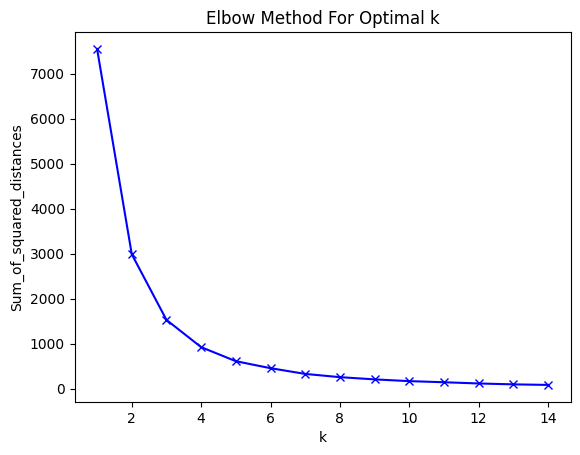

In [16]:
# get optimal number of topics
Sum_of_squared_distances = []
K = range(1,15)
for k in K:
    kmeans = KMeans(n_clusters=k, init='k-means++', max_iter=100)
    X = kmeans.fit(model.docvecs.doctag_syn0) ###using documnet vecter numbers. doctag_syn0 calls doc2vec that is trained earlier.
    Sum_of_squared_distances.append(kmeans.inertia_)

plt.plot(K, Sum_of_squared_distances, 'bx-')
plt.xlabel('k')
plt.ylabel('Sum_of_squared_distances')
plt.title('Elbow Method For Optimal k')
plt.show()

In [17]:
# elbow result shows 8 is the best
num_clusters = 6 ## or change to 6?
kmeans = KMeans(n_clusters=num_clusters, init='k-means++', max_iter=100) 
X = kmeans.fit(model.docvecs.doctag_syn0)
labels = kmeans.labels_.tolist()

# can get the representative words of each category 
# cosine similarity measure of the words
# LDA uses number of words in each review (prob of word uses)

In [18]:
l = kmeans.fit_predict(model.docvecs.doctag_syn0)
pca = PCA(n_components=2).fit(model.docvecs.doctag_syn0)
datapoint = pca.transform(model.docvecs.doctag_syn0)

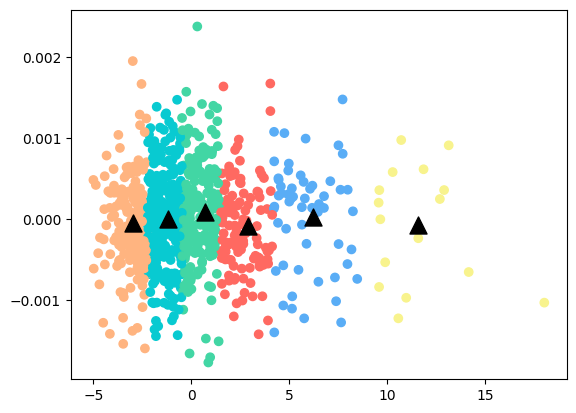

In [19]:
plt.figure
label1 = ["#FF6961", "#FFB480", "#F8F38D", "#42D6A4", "#08CAD1", "#59ADF6", "#9D94FF", "#C780E8"]
color = [label1[i] for i in labels]
plt.scatter(datapoint[:, 0], datapoint[:, 1], c=color)

centroids = kmeans.cluster_centers_
centroidpoint = pca.transform(centroids)
plt.scatter(centroidpoint[:, 0], centroidpoint[:, 1], marker='^', s=150, c='#000000')
plt.show()

# if clustering not well, means word embedding is not clearly representing the topic
# get a set of food items from wikipedia & set of sentiment words (e.g. good, nice, awful, costly) words that are freuently in reviews
# find the frequency of these words in the dataset??
# use n-grams?

In [20]:
# label each restaurant under 1 of the topics
restaurant_review_df['topics'] = labels

In [21]:
# count of restaurants under each topic
restaurant_review_df['topics'].value_counts()

4    270
3    211
1    173
0    118
5     57
2     16
Name: topics, dtype: int64

In [22]:
restaurant_review_df.head(5)

,url,cleaned_text,name,neighbourhood,price,categories,review,user,date,cleaned_price,...,Recommended,Sustainable,Novel,Desserts,Bites,Supper,Breakfast & Brunch,Halal,region,topics
0,https://www.burpple.com/108-matcha-saro?bp_ref...,matcha soft serve parfait deluxe s850 strong m...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nFish Ball Minced Meat Noodle\nFishball, meat...",Triffany Lim,21m ago,5.0,...,0,0,0,0,0,1,0,0,East,3
1,https://www.burpple.com/136-hong-kong-street-f...,favourite tze char place zhi char feast family...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']","\nOrh lua\nThere are a couple of stores, but g...",Ally Tan,Jul 30 at 4:12pm,5.0,...,0,0,0,0,0,1,0,0,East,4
2,https://www.burpple.com/15-stamford?bp_ref=%2F...,amaze four hand dinner chef alvin chef jay fou...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nPeanut sauce was ace\nI love a good satay pe...,Ally Tan,Jul 30 at 4:10pm,5.0,...,0,0,0,0,0,1,0,0,East,0
3,https://www.burpple.com/25-degrees-singapore?b...,burger oh yesh loveeeee burger goooooood locat...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nClassic BBQ wings\nJuicy and tasty like it’s...,Ally Tan,Jul 30 at 4:09pm,5.0,...,0,0,0,0,0,1,0,0,East,0
4,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%...,firebird 15 signature firebird koreaninspired ...,85 Fengshan Centre,Bedok,~$5/pax,"['Hawker Food', 'Supper', 'Cheap & Good']",\nBBQ stingray\nIt was yummy but slight warnin...,Ally Tan,Jul 30 at 4:08pm,5.0,...,0,0,0,0,0,1,0,0,East,0


## Interpret Clusters
identify restaurants that are closest to the centroid

In [23]:
from sklearn.metrics import pairwise_distances
distances = pairwise_distances(kmeans.cluster_centers_, model.docvecs.doctag_syn0, metric='euclidean')
closest_indexes = [np.argpartition(i, 10)[:10] for i in distances] # for each centroid, get the 10 nearest restaurants

In [24]:
interpret_df = pd.DataFrame(columns=['topics', 'url', 'cleaned_text'])
for idx in closest_indexes:
    interpret_df = interpret_df.append(restaurant_review_df[['url', 'cleaned_text', 'topics']].iloc[idx])

interpret_df = interpret_df.sort_values(['topics'])

In [25]:
interpret_df.to_csv('doc2vec_centroid_restaurants_' + str(num_clusters) + '_clusters.csv')

In [26]:
interpret_df[interpret_df['topics'] == 0]

,topics,url,cleaned_text
114,0,https://www.burpple.com/burgerlabo?bp_ref=%2Ff...,best burger singapore basic burger burgerlabo ...
45,0,https://www.burpple.com/amoy-street-hawker-cen...,signature char siu noodle elevate version usua...
74,0,https://www.burpple.com/bedrock-bar-grill?bp_r...,crème brûlée 16 good end lovely meal crème brû...
807,0,https://www.burpple.com/wimbly-lu-chocolates?b...,berry sure waffle waffle fluffy moist inside c...
61,0,https://www.burpple.com/bakalaki?bp_ref=%2Ff%2...,drop standard tiong bahru ambience great food ...
47,0,https://www.burpple.com/anjusg?bp_ref=%2F%40me...,galbijjim 76 traditional korean braise boneles...
794,0,https://www.burpple.com/wakanui-grill?bp_ref=%...,medium rare ribeye tender quiet place meeting ...
417,0,https://www.burpple.com/les-amis?bp_ref=%2Ff%2...,sincerer love love food face_savoring_food les...
481,0,https://www.burpple.com/miznon-singapore?bp_re...,pita broken chicken literally good stop think ...
804,0,https://www.burpple.com/whitegrass-restaurant?...,whitegrass helm head chef takuya yamashita sho...


## One Hot Encode

In [27]:
restaurant_review_df_encoded = restaurant_review_df.drop(['name', 'cleaned_text', 'price', 'categories', 'review', 'user', 'date', 'cleaned_categories'], axis=1)

In [28]:
# one hot encode region & topics
region_dummies = pd.get_dummies(restaurant_review_df_encoded['region'])
neighbourhood_dummies = pd.get_dummies(restaurant_review_df_encoded['neighbourhood'])
topic_dummies = pd.get_dummies(restaurant_review_df_encoded['topics'])

restaurant_review_df_encoded = restaurant_review_df_encoded.drop(['region', 'neighbourhood', 'topics'], axis=1)
restaurant_review_df_encoded = restaurant_review_df_encoded.join(region_dummies)
restaurant_review_df_encoded = restaurant_review_df_encoded.join(neighbourhood_dummies)
restaurant_review_df_encoded = restaurant_review_df_encoded.join(topic_dummies)

In [29]:
restaurant_review_df_encoded.head(5)

,url,cleaned_price,Healthy,Noodles,Indian,Seafood,BBQ,High Tea,Good Environment,Chinese,...,Potong Pasir,Serangoon,Tanjong Pagar,Tiong Bahru,0,1,2,3,4,5
0,https://www.burpple.com/108-matcha-saro?bp_ref...,5.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,1,0,0
1,https://www.burpple.com/136-hong-kong-street-f...,5.0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,1,0
2,https://www.burpple.com/15-stamford?bp_ref=%2F...,5.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
3,https://www.burpple.com/25-degrees-singapore?b...,5.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0
4,https://www.burpple.com/46-mittsu?bp_ref=%2Ff%...,5.0,0,0,0,0,0,0,0,0,...,0,0,0,0,1,0,0,0,0,0


In [30]:
restaurant_review_df_encoded.to_csv('doc2vec_labelled_restaurants.csv')

## WordCloud

In [31]:
from wordcloud import WordCloud
from sklearn.feature_extraction.text import TfidfVectorizer

In [32]:
# concatenate all the reviews for each topic
topic_df = interpret_df[['topics', 'cleaned_text']]
topic_df = topic_df.groupby(['topics'], as_index = False).agg({'cleaned_text': ' '.join})
topic_df

,topics,cleaned_text
0,0,best burger singapore basic burger burgerlabo ...
1,1,pizza maker crabmeat pasta thumbs_up_light_ski...
2,2,wokfried pork rib white sesame sweet sour sauc...
3,3,usual great deal great food user love brotzeit...
4,4,laksabig350 30 year strong legendary 928 yishu...
5,5,crack dawn tucked away katong amblingturtle do...


In [33]:
# TF-IDF
text = topic_df['cleaned_text']
vectorizer = TfidfVectorizer(stop_words='english')
X = vectorizer.fit_transform(text)
feature_names = vectorizer.get_feature_names_out()
dense = X.todense()
denselist = dense.tolist()
df = pd.DataFrame(denselist, columns=feature_names).transpose()
df.columns = topic_df['topics']

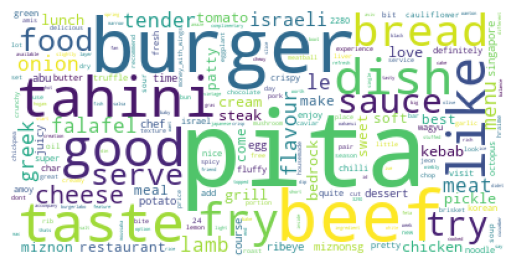

In [34]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(df[0])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

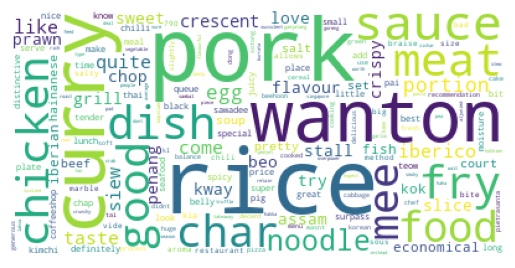

In [35]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(df[1])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

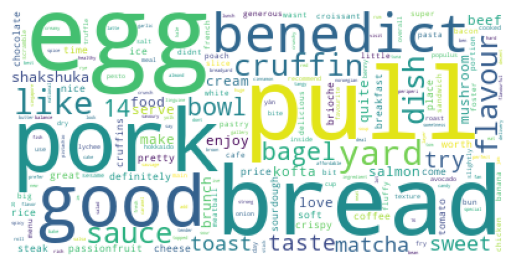

In [36]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(df[2])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

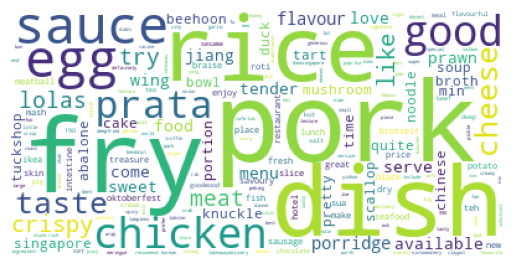

In [37]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(df[3])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

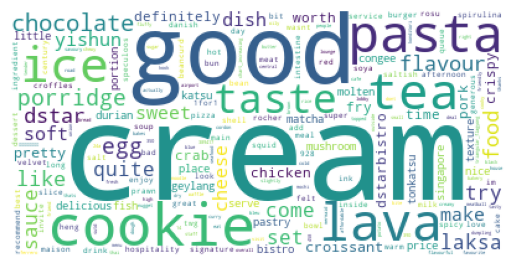

In [38]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(df[4])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

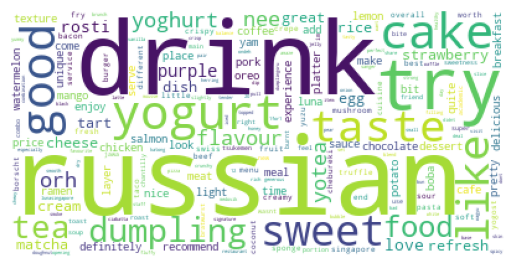

In [39]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(df[5])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

In [40]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(df[6])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()

KeyError: 6

In [ ]:
wordcloud = WordCloud(background_color = 'white').generate_from_frequencies(df[7])
# Display the generated Word Cloud
plt.imshow(wordcloud)
plt.axis("off")
plt.show()